# Simple Deep Learning Model - TensorFlow v1.15 (2 of 3)

This notebook is one in a series of three with a simple deep learning model built three ways the same to compare and contrast; with just Numpy, with TensorFlow without Keras (TF1.15) and TensorFlow 2 with Keras

### Summary of the model
#### Model
- The model is a 3-layer deep neural network with the following shape: 
LINEAR (10 Neurons) -> RELU -> LINEAR (5 Neurons) -> RELU -> LINEAR (1 Neuron) -> SIGMOID

The model build follows standard Deep Learning methodology:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation using activation functions at each layer
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and gradients from the 'backprop') 
    4. Use trained parameters to predict labels from a new set of data
    5. Review the performance of the model to see if it generalises well to new data
#### Parameter Initialisation
- Random parameters are chosen when they are initialised in a model to break symetery. Research has shown that He initialization works better for layers with ReLu activation. Xavier initialization works better for layers with sigmoid activation.

#### Activation Functions
- *ReLU* (Rectified Linear Unit) has superior properties over Sigmoid because it allowed to the solve vanishing / exploding gradients problem except...
- *Sigmoid* is especially useful for models which predict the probability as an output. Since probability of anything exists only between the range of 0 and 1, sigmoid is the right choice in the final layer. 

#### Cost (or loss) Function
- The model uses a straightforward 'log loss' calculation, also known as 'cross-entropy loss' to calculate the cost of the predictions vs the ground truth labels (y data) ,in this case binary cross-entropy as we are predicting 1s or 0s. .

#### Backward Propagation
- The model uses standard gradient descent also known as Stochastic gradient descent. We don't use any further optimisers such as momentum in this use-case.

#### Data
- Utlising a 2-dimensional binary classification dataset allows for the visualisation of a decision boundry learned by the model. In this case, 'make_circles' from Scikit-Learn,a simple toy dataset which produces Gaussian data with a spherical decision boundary.
- The model is universal though and can be used with data with many features, even image data.

Let's get started!

In [23]:
# conda install tensorflow==1.15

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow
import tensorflow as tf
from tensorflow.python.framework import ops

In [25]:
# Check version
print(tf.__version__)

1.15.0


In [26]:
# Import sklearn only for the dataset. 
import sklearn.datasets

def load_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y

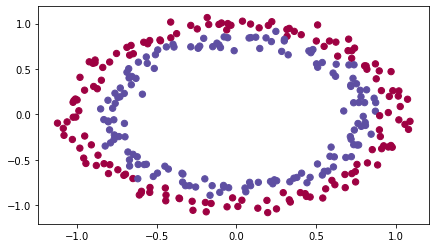

In [27]:
# load image dataset: blue/red dots in circles
X_train, Y_train, X_test, Y_test = load_dataset()

In [28]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 2
number of test examples = 2
X_train shape: (2, 300)
Y_train shape: (1, 300)
X_test shape: (2, 100)
Y_test shape: (1, 100)


In [29]:
# X_train

In [30]:
# Y_train

### TensorFlow

TensorFlow is developed for Machine Learning projects, focusing on Deep Learning. It is open source but governed by Google. Instead of writing the required steps natively in a programming language, TensorFlow is used to create computation graphs utilising many algorithmic advances made in the field of Machine Learning for example back-propagation optimisers, loss functions, activation functions and performance measurement. In TensorFlow 1.x. The writing of code was divided into two parts: building the computational graph and later creating a session to execute it.

TensorFlow utilises the GPU where available (Nvidia CUDA in Windows and Linux).

Higher level APIs for further abstraction have also been built to allow faster prototyping, eg Keras.

The following model is written natively in TensorFlow v1.15, however TensorFlow2.0 onwards has been available for over a year and TensorFlow2.0 Eager Execution is implemented by default, i.e. you no longer need to create a session to run the computational graph,  you can see the result of your code directly without the need of creating Session.

More info here: https://medium.com/tensorflow/whats-coming-in-tensorflow-2-0-d3663832e9b8

Writing and running programs in TensorFlow v1.0 utilise the following steps:

1. Create Tensors (variables) that are not yet executed/evaluated, these are called 'placeholders'. 
2. Write operations between those Tensors.
3. Initialize your Tensors. 
4. Create a Session. 
5. Run the Session. This will run the operations above. 

In [31]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of number of features in an example
    n_y -- scalar, number of classes in target eg 1
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"
    
    Notes:
    - None because it let's us be flexible on the number of examples for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32, shape = (n_x, None), name = "X")
    Y = tf.placeholder(tf.float32, shape = (n_y, None), name = "Y")

    
    return X, Y

In [32]:
def initialize_parameters(n_x, n_y):
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, input features (2)]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [output classes(1), 12]
                        b3 : [1, 1]
    
    ReLU layers using variance_scaling_initializer (Kaiming He)
    Sigmoid layers using xavier_initializer (Xavier Glorot)
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)   # so that output is consistent for testing
        
    W1 = tf.get_variable("W1", [10,n_x], initializer = tf.contrib.layers.variance_scaling_initializer(seed = 1))
    b1 = tf.get_variable("b1", [10,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [5,10], initializer = tf.contrib.layers.variance_scaling_initializer(seed = 1))
    b2 = tf.get_variable("b2", [5,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [n_y,5], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [n_y,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [33]:
(n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
n_y = Y_train.shape[0]

tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters(n_x, n_y)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    print("W3= " + str(parameters["W3"]))
    print("b3 = " + str(parameters["b3"]))


W1 = <tf.Variable 'W1:0' shape=(10, 2) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(10, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(5, 10) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(5, 1) dtype=float32_ref>
W3= <tf.Variable 'W3:0' shape=(1, 5) dtype=float32_ref>
b3 = <tf.Variable 'b3:0' shape=(1, 1) dtype=float32_ref>


In [34]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: 
    LINEAR(10) -> RELU -> LINEAR(5)-> RELU -> LINEAR(1)-> SIGMOID(seperate function)
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
                                                            # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, A1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3, A2) + b3
    
    return Z3

In [35]:
def compute_cost(logits, labels):
    """
    Computes the cost/loss only on the final layer using sigmoid_cross_entropy_with_logits, used for 
    classification, including can be used with multi class outputs
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (5, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # Use the loss function (approx. 1 line)
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits,  labels = labels))
    
    return cost

In [36]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.01,
          num_epochs = 40000, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)             # to keep consistent results
    (n_x, m) = X_train.shape          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]            # n_y : output size
    costs = []                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters (n_x, n_y)
    parameters = initialize_parameters(n_x, n_y)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0. # Defines a cost related to an epoch

            # Run the session to execute the "optimizer" and the "cost", the feedict should contain (X,Y).
            # Consider using mini-batches if number of training examples is large
            _ , epoch_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})

            # Print the cost every epoch
            if print_cost == True and epoch % 1000 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Loss using SGD - TF 1.15")
        plt.show()

        # save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        a3 = tf.round(tf.sigmoid(Z3))
        correct_prediction = tf.equal(a3, Y)
        

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 0.719507
Cost after epoch 1000: 0.668627
Cost after epoch 2000: 0.648312
Cost after epoch 3000: 0.610220
Cost after epoch 4000: 0.550119
Cost after epoch 5000: 0.469164
Cost after epoch 6000: 0.374995
Cost after epoch 7000: 0.286850
Cost after epoch 8000: 0.222719
Cost after epoch 9000: 0.179715
Cost after epoch 10000: 0.149307
Cost after epoch 11000: 0.127337
Cost after epoch 12000: 0.109979
Cost after epoch 13000: 0.097027
Cost after epoch 14000: 0.086136
Cost after epoch 15000: 0.078026
Cost after epoch 16000: 0.071388
Cost after epoch 17000: 0.065645
Cost after epoch 18000: 0.060688
Cost after epoch 19000: 0.056477
Cost after epoch 20000: 0.052764
Cost after epoch 21000: 0.049326
Cost after epoch 22000: 0.046174
Cost after epoch 23000: 0.043529
Cost after epoch 24000: 0.041297
Cost after epoch 25000: 0.039337
Cost after epoch 26000: 0.037620
Cost after epoch 27000: 0.036095
Cost after epoch 28000: 0.034734
Cost after epoch 29000: 0.033500
Cost after epoch 30000:

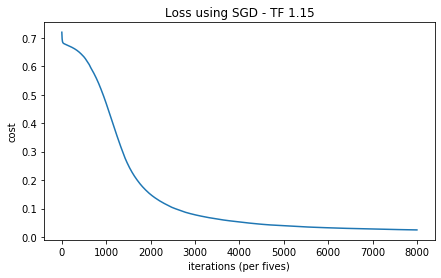

Parameters have been trained!
Train Accuracy: 0.99333334
Test Accuracy: 0.95


In [37]:
parameters = model(X_train, Y_train, X_test, Y_test)

In [38]:
def predict(parameters, X):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    m = X.shape[1]
    x = tf.placeholder("float32", [2, m])
    
    z3 = forward_propagation(x, params)
    a3 = tf.round(tf.sigmoid(z3))
    
    sess = tf.Session()
    prediction = sess.run(a3, feed_dict = {x: X})
        
    return prediction

In [39]:
X_test_results = predict(parameters, X_test)

In [40]:
# Y_test

In [41]:
compare = X_test_results == Y_test
print(compare)
type(compare)
print(compare.shape)

[[ True  True  True  True  True False  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True False  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True False  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True False  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True False  True  True]]
(1, 100)


In [42]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=np.reshape(y,-1), cmap=plt.cm.Spectral)
    plt.show()

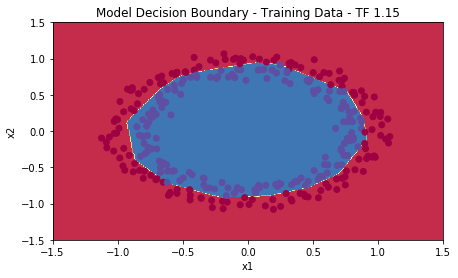

In [43]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.title("Model Decision Boundary - Training Data - TF 1.15")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict(parameters, x.T), X_train, Y_train)

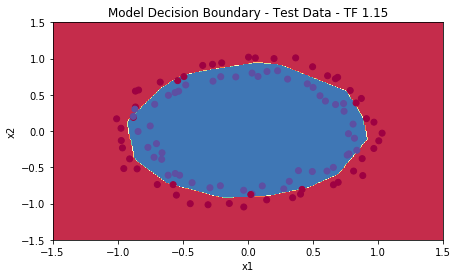

In [44]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.title("Model Decision Boundary - Test Data - TF 1.15")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict(parameters, x.T), X_test, Y_test)